# Simple Electrical Circuit

This notebook is a simple tutorial on how to use the julia package `BondGraphs.jl` to simulate a simple electrical circuit.

This tutorial has been adapted from https://bondgraphtools.readthedocs.io/en/latest/tutorials/RC.html

In [1]:
# Since BondGraphs is not yet in the package manager, we will need to include it directly from Github
# NOTE: You will need Julia >= 1.7
using Pkg; Pkg.add(url="https://github.com/jedforrest/BondGraphs.jl")
using BondGraphs

Our first example will be a simple electric circuit of a capacitor, resistor, and current supply in parallel. We will first model this circuit without the current supply.

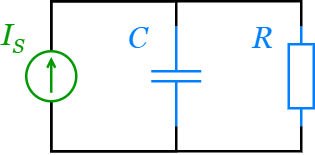

## Model Construction
We first create a `BondGraph` object which will hold all our components

In [2]:
model = BondGraph("RC Circuit")

BondGraph RC Circuit (0 Nodes, 0 Bonds)

We then create all the components of our model. Each component contains a constitutive equation which builds our model

In [3]:
C = Component(:C)
description(:C)

Generalised Linear Capacitor
e = (1/C)*q
dq/dt = f
C: Capacitance [1.0]
q: Generalised position [0.0]


In [4]:
constitutive_relations(C)

2-element Vector{Symbolics.Equation}:
 0 ~ q(t) / C - (E(t))[1]
 Differential(t)(q(t)) ~ (F(t))[1]

In [5]:
R = Component(:R)
constitutive_relations(R)

1-element Vector{Symbolics.Equation}:
 0 ~ (E(t))[1] - R*(F(t))[1]

We also create an `EqualEffort` node which represents Kirchoff's Voltage Law for shared effort (voltage) between components

In [6]:
kvl = EqualEffort()

𝟎

Components and nodes are added to the model, and connected together as a graph network

In [7]:
add_node!(model, [C, R, kvl])
connect!(model, R, kvl)
connect!(model, C, kvl)
model

BondGraph RC Circuit (3 Nodes, 2 Bonds)

Our bond graph is fundamentally a graph object, and can be manipulated using Julia's graph functionality

In [8]:
using Graphs
adjacency_matrix(model)

3×3 SparseArrays.SparseMatrixCSC{Int64, Int64} with 2 stored entries:
 ⋅  ⋅  1
 ⋅  ⋅  1
 ⋅  ⋅  ⋅

We can view our model structure by plotting the bond graph as a graph network. A plot recipe is available for `Plots.jl`

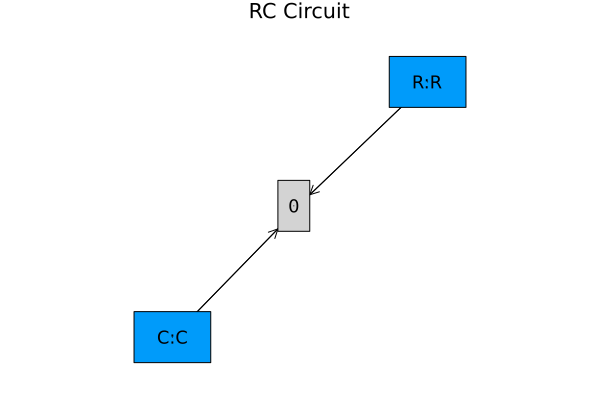

In [9]:
using Plots
plot(model, fontsize=12)

## Simulating our Model
With a bond graph we can automatically generate a series of differential equations which combine all the constitutive relations from the components, with efforts and flows shared according to the graph structure.

In [10]:
constitutive_relations(model)

1-element Vector{Symbolics.Equation}:
 Differential(t)(C₊q(t)) ~ (-C₊q(t)) / (C₊C*R₊R)

We set values for parameters in the graph model itself. Each component comes with default values.

When substituted into our equations, we get the following relation for the capacitor charge `C.q(t)`

In [11]:
C.C = 1
R.R = 2
constitutive_relations(model; sub_defaults=true)

1-element Vector{Symbolics.Equation}:
 Differential(t)(C₊q(t)) ~ (-C₊q(t)) / 2

We can solve this the bond graph directly using the in-built `simulate` function.

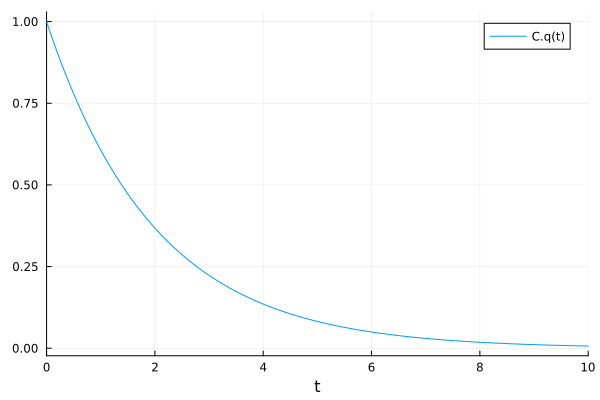

In [12]:
tspan = (0., 10.)
u0 = [1] # initial value for C.q(t)
sol = simulate(model, tspan; u0)
plot(sol)

Under the hood, our `simulate` function is converting our bond graph into an `ODESystem` from `ModelingToolkit.jl`.

We can chose instead to create an `ODESystem` directly and handle it with whatever tools we like.

In [13]:
using ModelingToolkit
sys = ODESystem(model)
display("text/plain", sys)

Model RC Circuit with 1 equations
States (1):
  C₊q(t) [defaults to 0.0]
Parameters (2):
  C₊C [defaults to 1]
  R₊R [defaults to 2]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 1 stored entry:
 ⋅  ×

## Expanding the circuit with a current supply
We will expand our model by adding an external current (flow) supply in parallel, represented by the component `Sf` (Source of Flow)

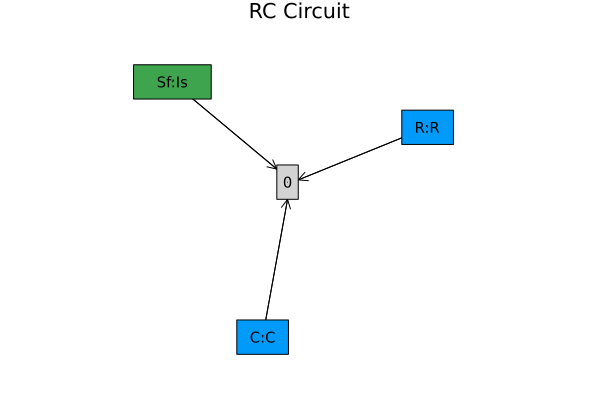

In [14]:
Is = Component(:Sf, "Is")
add_node!(model, Is)
connect!(model, Is, kvl)
plot(model, fontsize = 10)

The simplest external input is a constant. We set the parameter function of the current supply component to be `fs(t) = 2`. Note the additional '2' in the constitutive relation below

In [15]:
Is.fs = t -> 2 # Note that this is still a function of time
constitutive_relations(model)

1-element Vector{Equation}:
 Differential(t)(C₊q(t)) ~ (2.0C₊C*R₊R - C₊q(t)) / (C₊C*R₊R)

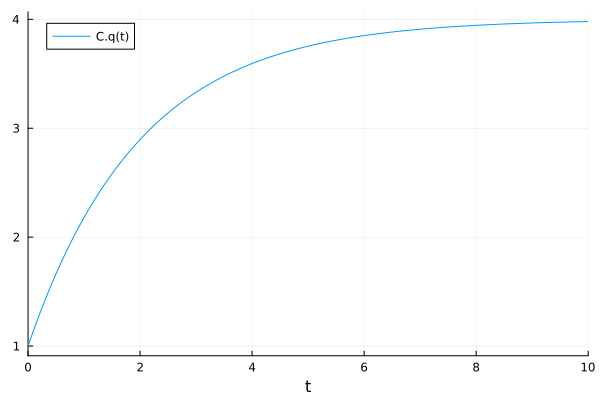

In [16]:
sol = simulate(model, tspan; u0)
plot(sol)

The forcing function can be more complex, such as `fs(t) = sin(2t)`

In [17]:
Is.fs = t -> sin(2t)
constitutive_relations(model; sub_defaults=true)

1-element Vector{Equation}:
 Differential(t)(C₊q(t)) ~ (2sin(2t) - C₊q(t)) / 2

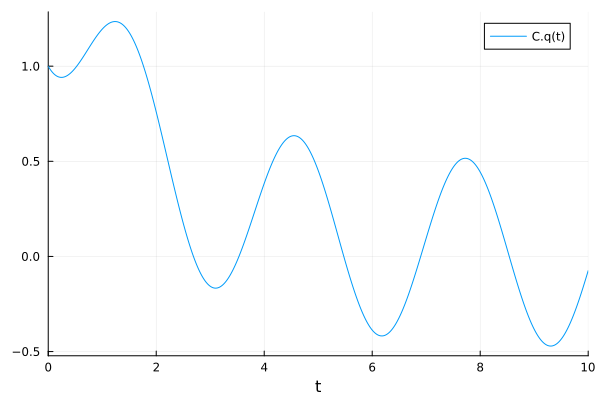

In [18]:
sol = simulate(model, tspan; u0)
plot(sol)

The input can be any arbitrary julia function of t, so long as it returns a sensible output. Note that for this to work you must register the custom function with `@register_symbolic`, so that the library knows not to simplify this function further. Note the addition of `f(t)` in the equation.

In [19]:
f(t) = t % 2 <= 1 ? 0 : 1 # repeating square wave
@register_symbolic f(t)

Is.fs = t -> f(t)
constitutive_relations(model; sub_defaults=true)

1-element Vector{Equation}:
 Differential(t)(C₊q(t)) ~ (2f(t) - C₊q(t)) / 2

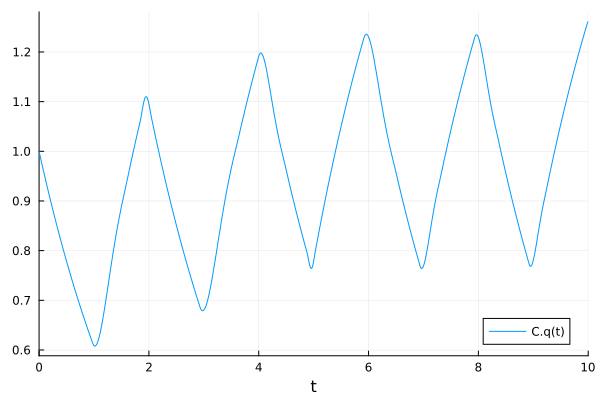

In [20]:
sol = simulate(model, tspan; u0)
plot(sol)

Once a function `f(t)` is registered in in the model, it can be repeatedly modified and called without having to reconstruct the model

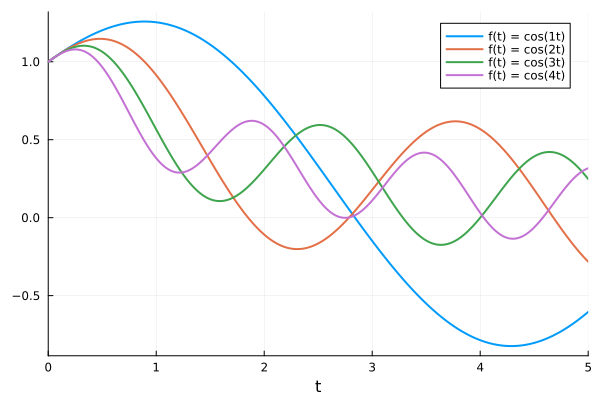

In [21]:
p = plot();
for i in 1:4
    f(t) = cos(i * t)
    sol = simulate(model, (0., 5.); u0)
    plot!(p, sol, label = "f(t) = cos($(i)t)", lw=2)
end
plot(p)